In [100]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.estimator import BoostedTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt

### Load the Iris Dataset

In [101]:
iris = load_iris()

In [102]:
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])

In [103]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [104]:
df['target'].value_counts()

2.0    50
1.0    50
0.0    50
Name: target, dtype: int64

In [105]:
col_names = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
target_names = ['Setosa', 'Versicolor', 'Virginica']

### Rename Column names

In [106]:
col_dict = {}
df_col = list(df.columns)
for idx in range(len(df_col)):
  col_dict[df_col[idx]] = col_names[idx]

df = df.rename(columns=col_dict)

In [107]:
df.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### as we are considering binary class classification then we have to take only two classes

In [108]:
df= df[df['Species']>=1]
map_dict = {1.0: 0, 2.0: 1}
df = df.replace({"Species": map_dict})
df['Species'] = df['Species'].astype(np.int64)

In [109]:
df.Species.value_counts()

1    50
0    50
Name: Species, dtype: int64

In [110]:
df.reset_index(inplace=True, drop=True)


In [111]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SepalLength,100.0,6.262,0.662834,4.9,5.800,6.3,6.700,7.9
SepalWidth,100.0,2.872,0.332751,2.0,2.700,2.9,3.025,3.8
PetalLength,100.0,4.906,0.825578,3.0,4.375,4.9,5.525,6.9
PetalWidth,100.0,1.676,0.424769,1.0,1.300,1.6,2.000,2.5
Species,100.0,0.500,0.502519,0.0,0.000,0.5,1.000,1.0


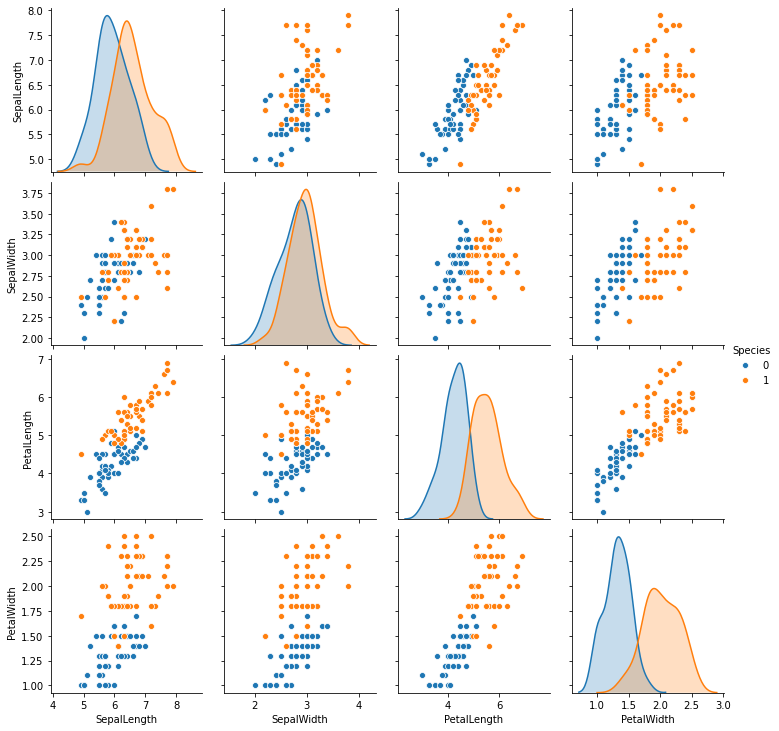

In [112]:
sns.pairplot(df,diag_kind='auto',hue='Species')

in the above graph, The diagonal row is simply a histogram of each variable and number of occurrences.
The bottom left is same as the top right with the axes flipped.
the graphs apart from the diagonal showing the positive or negative correlation between variables

In [113]:
corr_data = df.corr()
corr_data.style.background_gradient(cmap='coolwarm',axis=None)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
SepalLength,1.000000,0.553855,0.828479,0.593709,0.494305
SepalWidth,0.553855,1.000000,0.519802,0.566203,0.308080
PetalLength,0.828479,0.519802,1.000000,0.823348,0.786424
PetalWidth,0.593709,0.566203,0.823348,1.000000,0.828129
Species,0.494305,0.308080,0.786424,0.828129,1.000000


this is a correlation matrix between each variable.

In [114]:
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

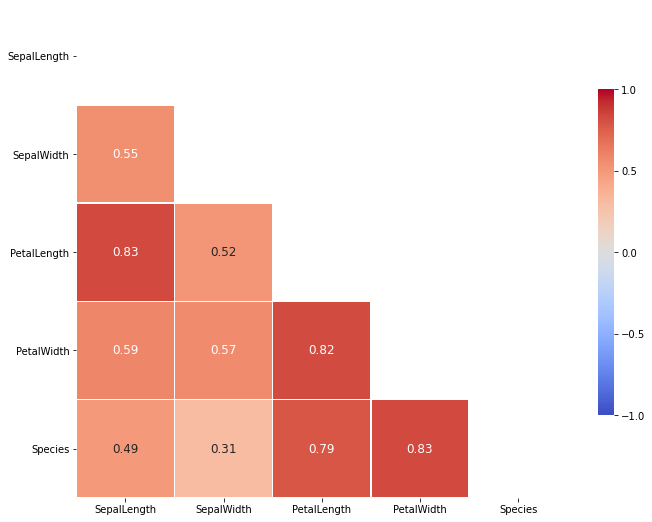

In [115]:
f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_data, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
#add the column names as labels
ax.set_yticklabels(corr_data.columns, rotation = 0)
ax.set_xticklabels(corr_data.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Select the Required Columns

In [116]:
y_df = df[['Species']]
x_df = df.drop('Species',axis=1)
train_x, test_x, train_y, test_y  = train_test_split(x_df, y_df, test_size=0.2)

### Normalize the data
There are different ways of performing data normalization e.g. using sklearn standard scalar, minMax Scalar etc.


In [117]:
def norm(x):
  s = x.describe().transpose()
  return (x-s['mean'])/s['std']

norm_train_x = norm(train_x)
norm_test_x = norm(test_x)

### Build the Input Pipeline for Tensorflow Model

In [118]:
def input(df, target, epochs=10,shuffle=True, batch_size = 32):
  def input_feed_function():
    dataset = tf.data.Dataset.from_tensor_slices((dict(df),target))
    if shuffle:
      dataset.shuffle(2000)
    dataset = dataset.batch(batch_size).repeat(epochs)
    return dataset
  return input_feed_function

In [119]:
train_inp = input(norm_train_x, train_y)
train_inp_testing = input(norm_train_x,train_y,epochs=1,shuffle=False)

test_inp = input(norm_test_x, test_y)
test_inp_testing = input(norm_test_x,test_y,epochs=1,shuffle=False)

### Model Training

In [120]:
col_num = [tf.feature_column.numeric_column(m) for m in train_x.columns]

In [121]:
col_num

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [122]:
model = BoostedTreesClassifier(feature_columns = col_num, n_batches_per_layer=1)
model.train(train_inp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpp9er852q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


### Model Predictions

In [123]:
train_pred = model.predict(train_inp_testing)
test_pred = model.predict(test_inp_testing)

In [124]:
train_pred = [int(p['classes'][0]) for p in train_pred]
test_pred = [int(p['classes'][0]) for p in test_pred]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpp9er852q/model.ckpt-29
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpp9er852q/model.ckpt-29
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [125]:
train_pred_df = pd.DataFrame(train_pred, columns=['prediction'])
test_pred_df = pd.DataFrame(test_pred, columns=['prediction'])

In [126]:
train_pred_df = pd.concat([train_y, train_pred_df], axis=1)
test_pred_df = pd.concat([test_y, test_pred_df], axis=1)

### Validation

In [127]:
def calculate_accuracy_metrices(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred) 
  precision = precision_score(y_true, y_pred) 
  recall = recall_score(y_true, y_pred) 
  return accuracy, precision, recall

print("________________________Training Accuracy_____________________")
train_res = calculate_accuracy_metrices(list(train_y['Species']), train_pred)
print(train_res)
print("Train Accuracy : ", train_res[0])
print("Train Precision : ", train_res[1])
print("Train Recall : ", train_res[2])
print("________________________Testing Accuracy_____________________")
test_res = calculate_accuracy_metrices(list(test_y['Species']), test_pred)
print(test_res)
print("Test Accuracy : ", test_res[0])
print("Test Precision : ", test_res[1])
print("Test Recall : ", test_res[2])

________________________Training Accuracy_____________________
(0.975, 0.95, 1.0)
Train Accuracy :  0.975
Train Precision :  0.95
Train Recall :  1.0
________________________Testing Accuracy_____________________
(0.9, 0.9166666666666666, 0.9166666666666666)
Test Accuracy :  0.9
Test Precision :  0.9166666666666666
Test Recall :  0.9166666666666666
